##**Regression with a Flood Prediction Dataset**

#**Problem Statement**

Flood detection refers to the process of identifying, monitoring, and alerting authorities or individuals about the presence or likelihood of flooding in a particular area. It involves the use of various technologies and methods to detect, predict, and mitigate the impacts of floods.



#**Flood Prediction Dataset Description**

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Flood Prediction Factors dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance. It has 22 attributes, as below mentioned:


*   id
*   MonsoonIntensity: Intensity of monsoon rains.
*   TopographyDrainage: The efficiency of drainage as a function of the topography of the area.
*   RiverManagement: Management of rivers and river flows.
*   Deforestation: The rate of deforestation in countries.
*   Urbanization: The level of urban development.
*   ClimateChange: Climate change.
*   DamsQuality: Quality of dams and dams.
*   Siltation: The level of clogging of river beds and reservoirs.
*   Agricultural Practices: The practices of agriculture, including land use and irrigation systems.
*   Encroachments: Illegal occupation of lands and water bodies.
*   Ineffective disaster preparedness: Insufficient preparedness for emergencies and natural disasters.
*   Drainage systems: Condition of drainage and sewerage systems.
*   Coastal vulnerability: Vulnerability of coastal areas to flooding.
*   Landslides: Risk of landslides and landslides.
*   Watersheds: Condition of watersheds.
*   Deterioration of infrastructure: Degradation of workers.
*   PopulationScore: Population density and related factors.
*   WetlandLosss: Wetland loss and waterbody conditions.
*   Inadequate planning: Insufficient planning and problem management.
*   Political factors: Political factors influencing flood risk.
*   FloodProbability: Probability of flood occurrence.














In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.5 MB/s eta 0:00:00


In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.8 MB/s eta 0:00:00


In [3]:
# Import Libraries

import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
from scipy.stats import skew
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import  KFold, cross_val_score, cross_validate, train_test_split
from sklearn.ensemble import StackingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import optuna
from optuna.samplers import TPESampler
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d  brijlaldhankour/flood-prediction-factors -p /content
# !unzip -q flood-prediction-factors.zip -d /content/original_dataset

!kaggle competitions download -c playground-series-s4e5 -p /content
!unzip -q playground-series-s4e5.zip -d /content/dataset

 32% 9.00M/28.0M [00:00<00:00, 26.2MB/s]
100% 28.0M/28.0M [00:00<00:00, 67.4MB/s]


In [5]:
#Loading the Dataset
train_data = pd.read_csv('/content/dataset/train.csv')
test_data = pd.read_csv('/content/dataset/test.csv')


print('Shape of train data is : ' , train_data.shape)
print('train data columns: ' , train_data.columns)

Shape of train data is :  (1117957, 22)
train data columns:  Index(['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')


In [ ]:
# Use Original dataset in training set
# #Loading the Original Dataset
# original_data = pd.read_csv('/content/original_dataset/flood.csv')

# print('Shape of train data is : ' , original_data.shape)
# print('train data columns: ' , original_data.columns)

In [6]:
train_data = train_data.drop(['id'] , axis=1)

# train_data = pd.concat([train_data, original_data], ignore_index=True)
print('Shape of X is : ' , train_data.shape)

Shape of X is :  (1117957, 21)


In [7]:
duplicated_rows = train_data.duplicated()
sum(duplicated_rows)

0

#**Data Exploration**


In [8]:
#check the head of dataset
train_data.head(5)

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [9]:
#some information about the attributes(datatypes & null values)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1117957 non-null  int64  
 1   TopographyDrainage               1117957 non-null  int64  
 2   RiverManagement                  1117957 non-null  int64  
 3   Deforestation                    1117957 non-null  int64  
 4   Urbanization                     1117957 non-null  int64  
 5   ClimateChange                    1117957 non-null  int64  
 6   DamsQuality                      1117957 non-null  int64  
 7   Siltation                        1117957 non-null  int64  
 8   AgriculturalPractices            1117957 non-null  int64  
 9   Encroachments                    1117957 non-null  int64  
 10  IneffectiveDisasterPreparedness  1117957 non-null  int64  
 11  DrainageSystems                  1117957 non-null 

In [10]:
#Check statistical information of numerical values

numerical_features = train_data.select_dtypes(include=[np.number])
train_data.describe(include=[np.number]).transpose()

,count,mean,std,min,25%,50%,75%,max
MonsoonIntensity,1117957.0,4.921450,2.056387,0.000,3.00,5.000,6.00,16.000
TopographyDrainage,1117957.0,4.926671,2.093879,0.000,3.00,5.000,6.00,18.000
RiverManagement,1117957.0,4.955322,2.072186,0.000,4.00,5.000,6.00,16.000
Deforestation,1117957.0,4.942240,2.051689,0.000,4.00,5.000,6.00,17.000
Urbanization,1117957.0,4.942517,2.083391,0.000,3.00,5.000,6.00,17.000
ClimateChange,1117957.0,4.934093,2.057742,0.000,3.00,5.000,6.00,17.000
DamsQuality,1117957.0,4.955878,2.083063,0.000,4.00,5.000,6.00,16.000
Siltation,1117957.0,4.927791,2.065992,0.000,3.00,5.000,6.00,16.000
AgriculturalPractices,1117957.0,4.942619,2.068545,0.000,3.00,5.000,6.00,16.000
Encroachments,1117957.0,4.949230,2.083324,0.000,4.00,5.000,6.00,18.000


In [11]:
# Get the number of unique values for each column
unique_counts = train_data.nunique()
print(unique_counts)

MonsoonIntensity                   17
TopographyDrainage                 19
RiverManagement                    17
Deforestation                      18
Urbanization                       18
ClimateChange                      18
DamsQuality                        17
Siltation                          17
AgriculturalPractices              17
Encroachments                      19
IneffectiveDisasterPreparedness    17
DrainageSystems                    18
CoastalVulnerability               18
Landslides                         17
Watersheds                         17
DeterioratingInfrastructure        18
PopulationScore                    19
WetlandLoss                        20
InadequatePlanning                 17
PoliticalFactors                   17
FloodProbability                   83
dtype: int64


In [12]:
value_frequencies = {}
for col in train_data.columns:
    value_counts = train_data[col].value_counts()
    value_frequencies[col] = value_counts

for col in train_data.columns:
    print(f"Column '{col}':")
    print(f"Number of unique values: {unique_counts[col]}")
    print("Value frequencies:")
    print(value_frequencies[col])
    print()

Column 'MonsoonIntensity':
Number of unique values: 17
Value frequencies:
MonsoonIntensity
5     220936
4     214344
6     169080
3     160574
7     109210
2      86683
8      65954
9      33515
1      28946
10     14040
11      5851
0       5431
12      2062
13       729
14       391
15       169
16        42
Name: count, dtype: int64

Column 'TopographyDrainage':
Number of unique values: 19
Value frequencies:
TopographyDrainage
5     221252
4     213368
3     161989
6     159003
7     102681
2      90058
8      72000
9      37544
1      29422
10     15524
11      6177
0       5541
12      2199
13       705
14       333
15       106
16        42
17        10
18         3
Name: count, dtype: int64

Column 'RiverManagement':
Number of unique values: 17
Value frequencies:
RiverManagement
5     218216
4     214079
6     167368
3     160049
7     108538
2      83782
8      71204
9      36232
1      28872
10     15170
11      5773
0       5407
12      2120
13       715
14       297
15      

#Check distribution & skewness

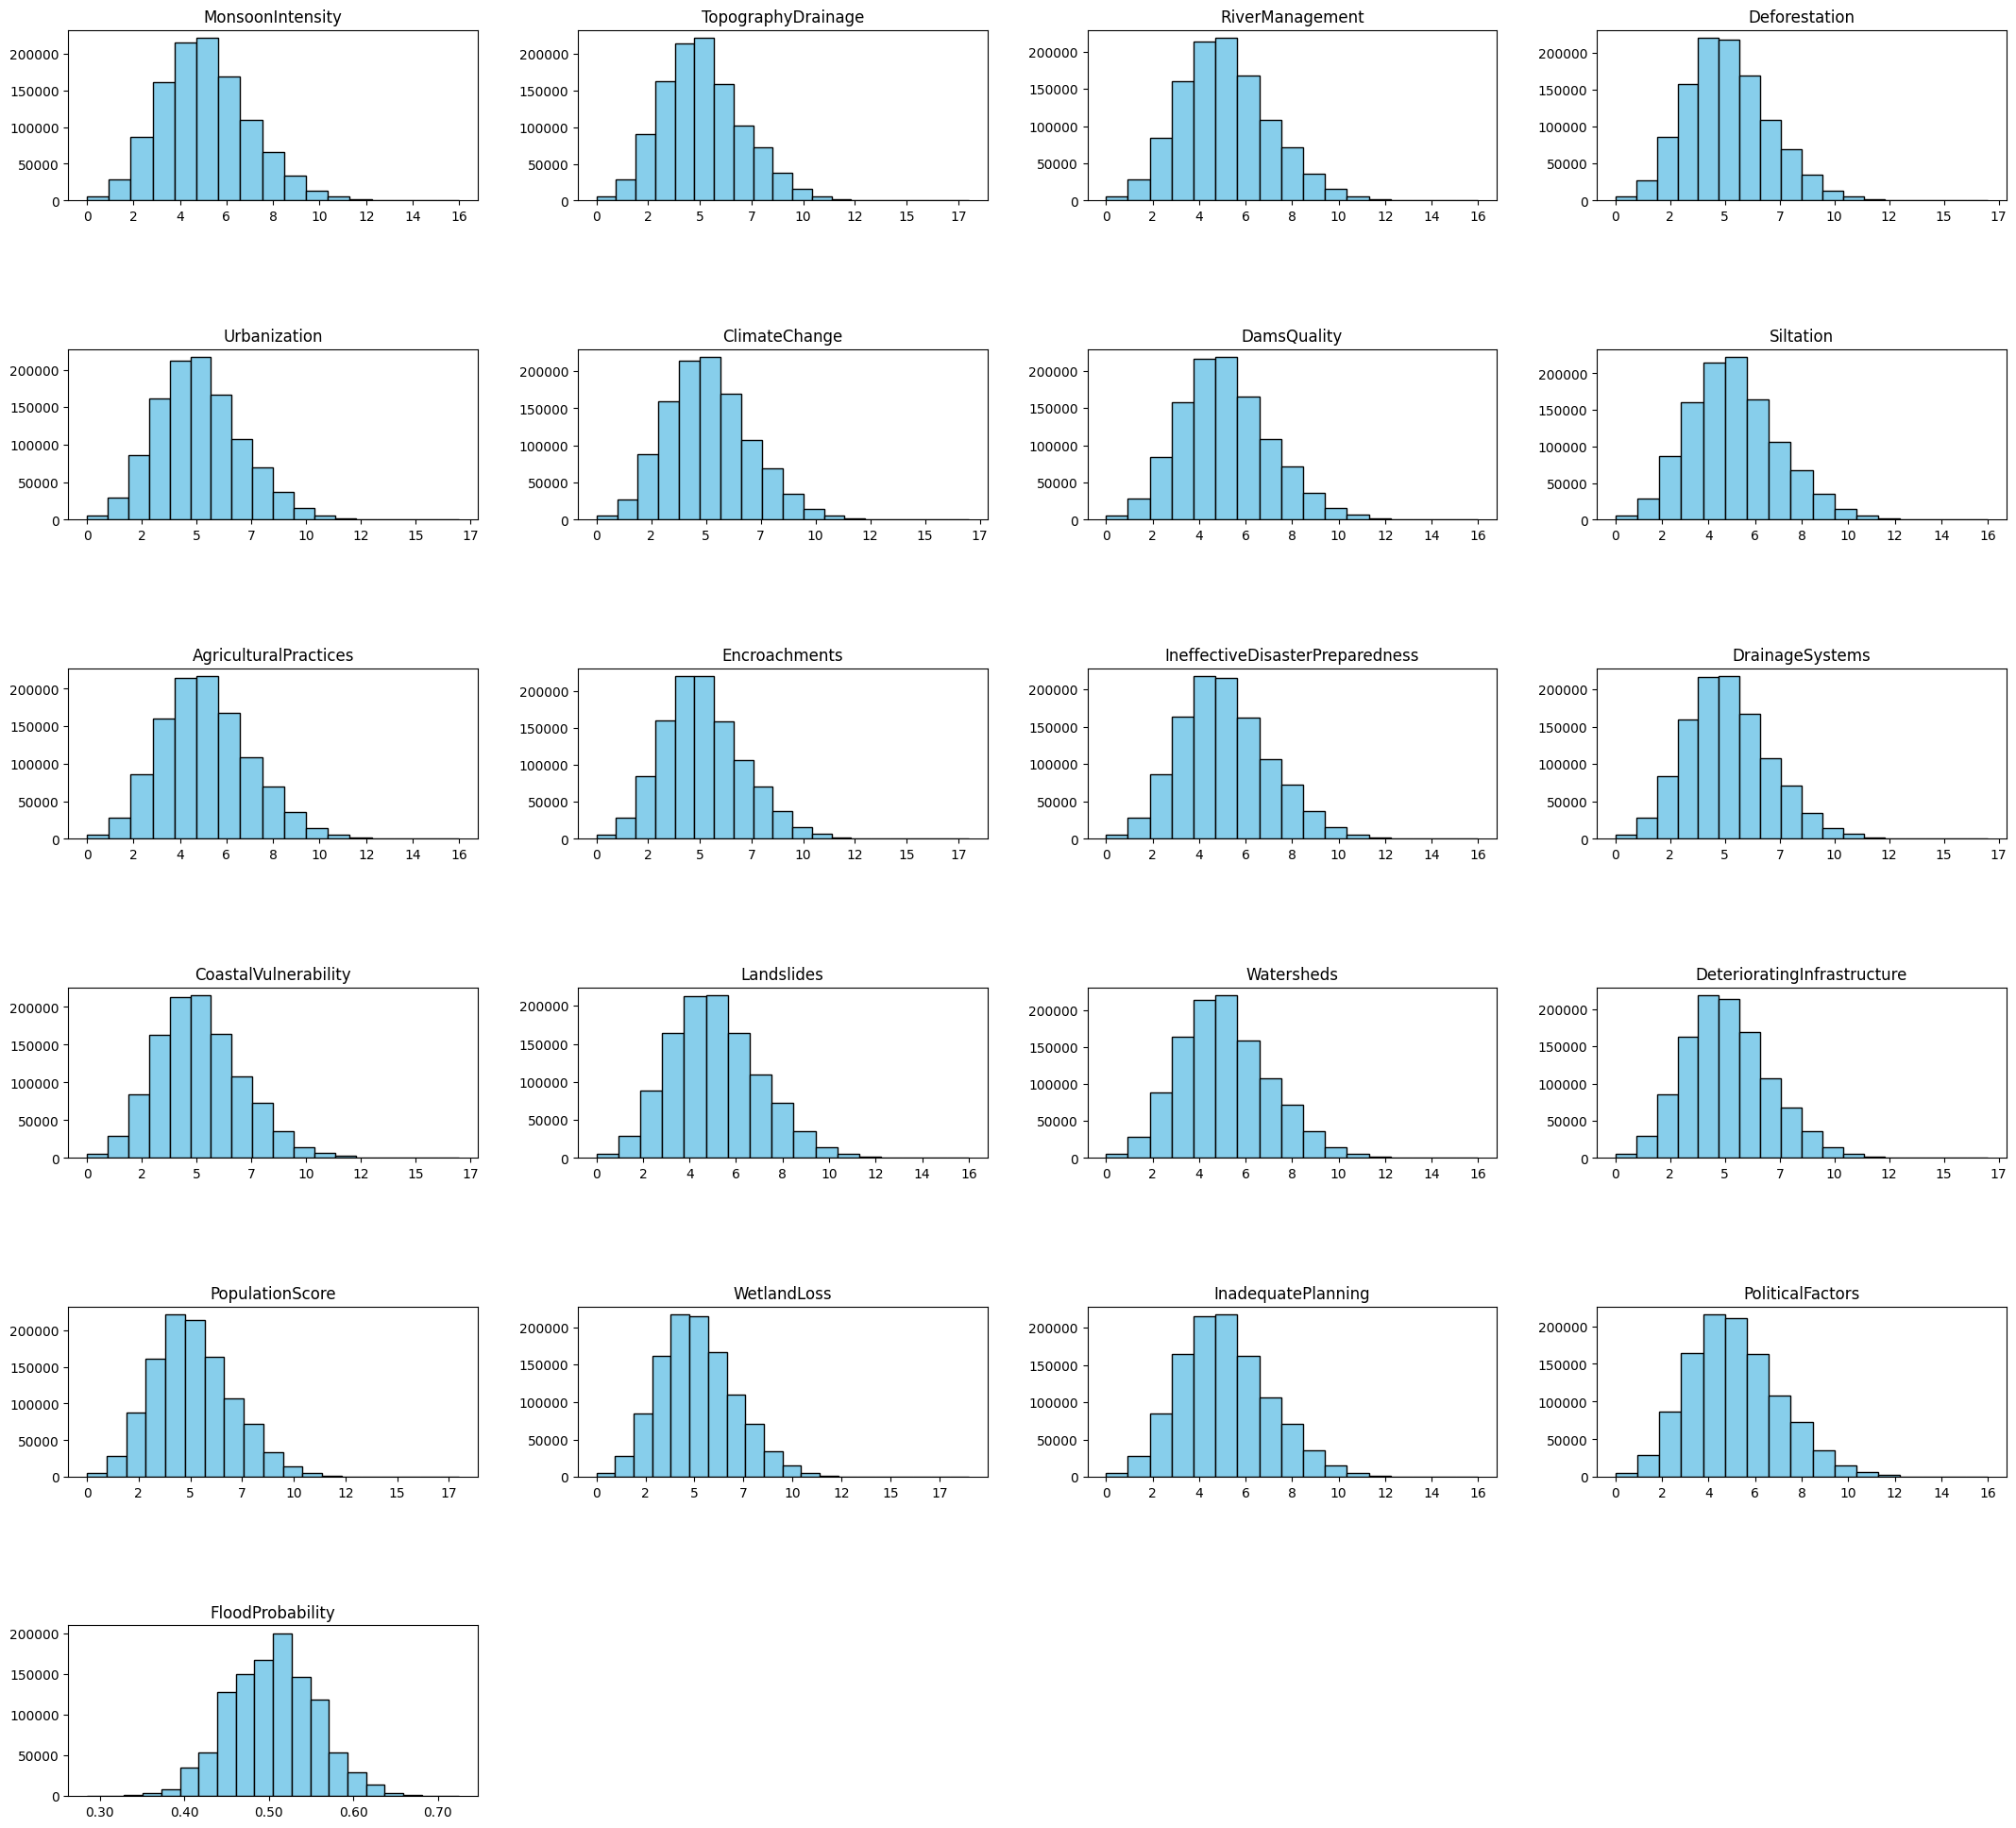

In [13]:
#distribution of numerical features
fig, axs = plt.subplots(ncols=4, nrows=6, figsize=(22, 20))
index = 0
axs_flatten = axs.flatten()

for k, v in numerical_features.items():
    row_index = index // 4
    col_index = index % 4
    bins = min(len(set(v)), 20)
    axs_flatten[index].hist(v, bins=bins, color='skyblue', edgecolor='black')
    axs_flatten[index].set_title(k)

    # Set x-axis tick formatter based on data type
    if np.issubdtype(v.dtype, np.integer):
        axs_flatten[index].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x)}'))
    elif np.issubdtype(v.dtype, np.floating):
        axs_flatten[index].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.2f}'))

    index += 1

# Hide any empty subplots
for ax in axs_flatten[index:]:
    fig.delaxes(ax)

plt.tight_layout(pad=3, w_pad=3, h_pad=8.0)
plt.show()


In [14]:
skew_features = train_data.skew().sort_values(ascending=False)
skew_features

Encroachments                      0.463551
TopographyDrainage                 0.458728
InadequatePlanning                 0.455136
PopulationScore                    0.451415
Watersheds                         0.450488
Siltation                          0.449248
MonsoonIntensity                   0.444528
DeterioratingInfrastructure        0.444167
IneffectiveDisasterPreparedness    0.443369
Urbanization                       0.442168
DrainageSystems                    0.441420
DamsQuality                        0.441402
CoastalVulnerability               0.439917
PoliticalFactors                   0.437561
WetlandLoss                        0.437045
Deforestation                      0.434314
ClimateChange                      0.429403
RiverManagement                    0.426491
Landslides                         0.425099
AgriculturalPractices              0.421145
FloodProbability                   0.047226
dtype: float64

#check outliers & handle it

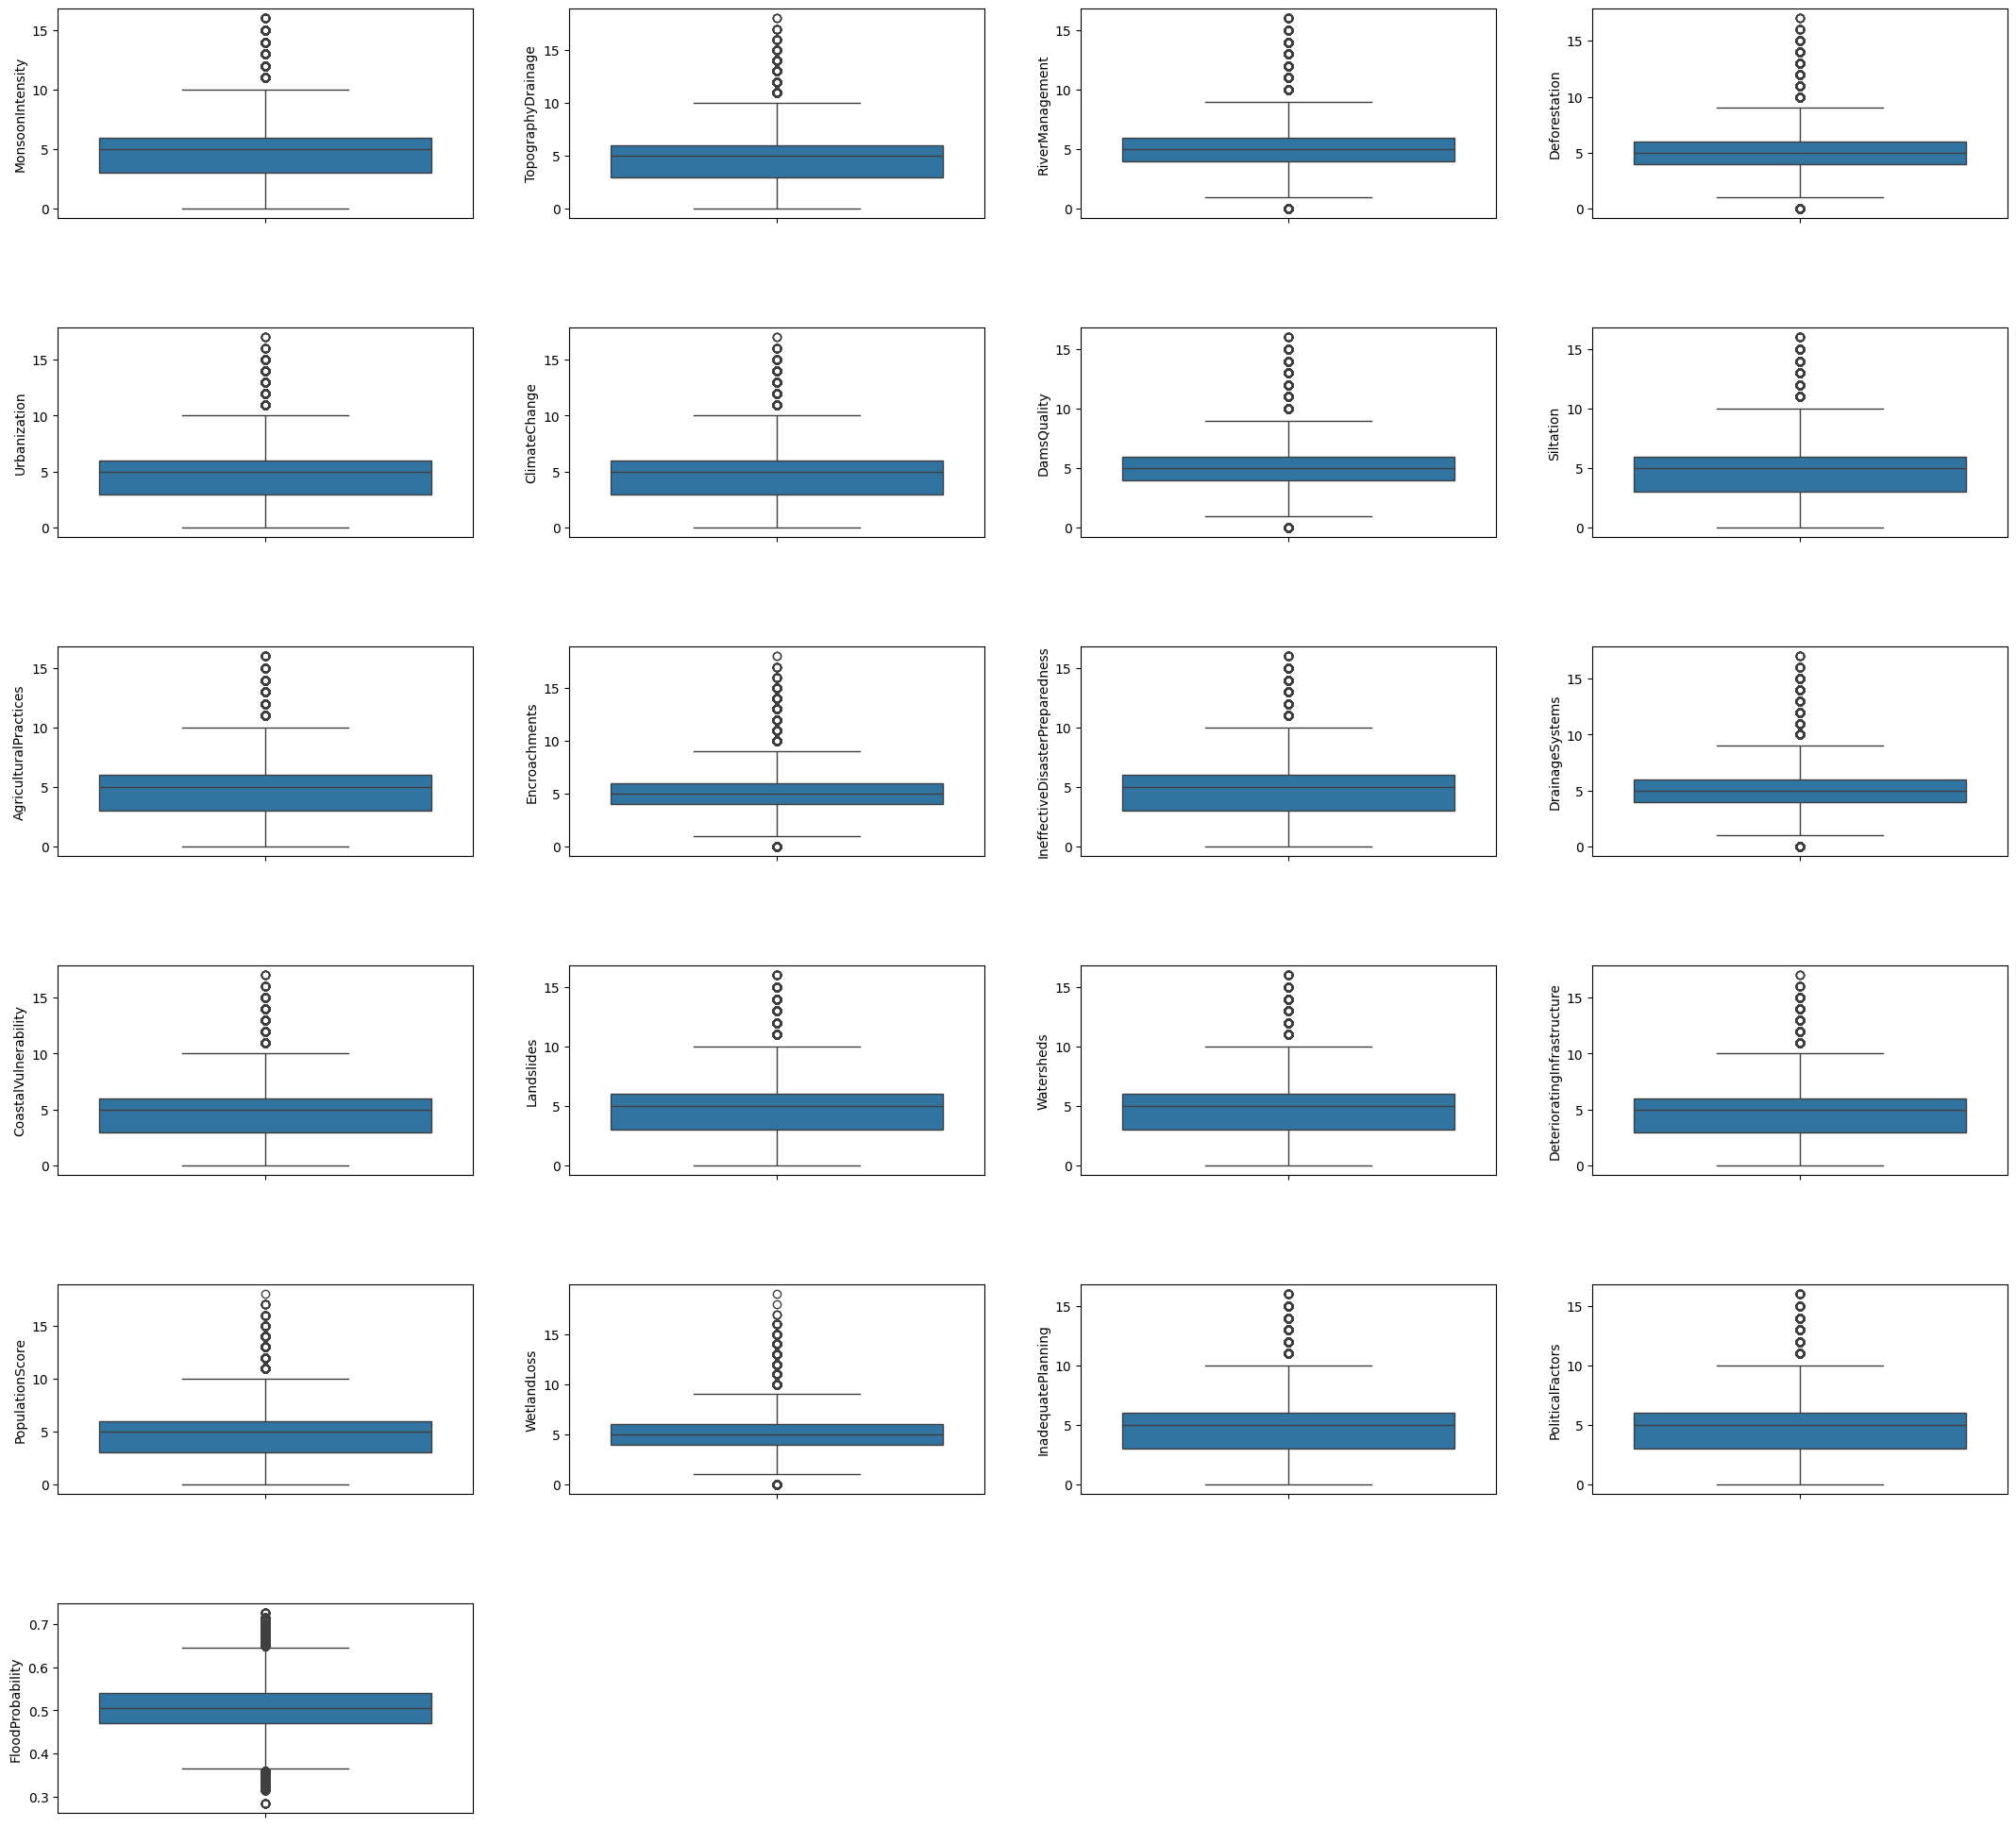

In [15]:
#Boxplot
fig, axs = plt.subplots(ncols=4, nrows=6, figsize=(22, 20))
index = 0
axs = axs.flatten()
for k,v in train_data.select_dtypes(include=[np.number]).items():
    sns.boxplot(y=k, data=train_data, ax=axs[index])
    index += 1

# Hide any empty subplots
for ax in axs[index:]:
    fig.delaxes(ax)
plt.tight_layout(pad=3, w_pad=4, h_pad=8.0)

In [16]:
# Define a function to find outliers based on IQR
def find_outliers(df):
    outliers = {}
    imputed_df = df.copy()
    for col in df.columns:
        v = df[col]
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers_count = ((v < lower_bound) | (v > upper_bound)).sum()
        perc = outliers_count * 100.0 / len(df)
        outliers[col] = (perc, outliers_count)
        print(f"Column {col} outliers = {perc:.2f}% ({outliers_count} out of {len(df)})")

    return outliers

# Find outliers in the DataFrame
outliers = find_outliers(train_data)

Column MonsoonIntensity outliers = 0.83% (9244 out of 1117957)
Column TopographyDrainage outliers = 0.86% (9575 out of 1117957)
Column RiverManagement outliers = 2.65% (29617 out of 1117957)
Column Deforestation outliers = 2.53% (28235 out of 1117957)
Column Urbanization outliers = 0.82% (9184 out of 1117957)
Column ClimateChange outliers = 0.78% (8702 out of 1117957)
Column DamsQuality outliers = 2.78% (31097 out of 1117957)
Column Siltation outliers = 0.81% (9079 out of 1117957)
Column AgriculturalPractices outliers = 0.81% (9006 out of 1117957)
Column Encroachments outliers = 2.79% (31141 out of 1117957)
Column IneffectiveDisasterPreparedness outliers = 0.80% (8945 out of 1117957)
Column DrainageSystems outliers = 2.69% (30060 out of 1117957)
Column CoastalVulnerability outliers = 0.91% (10209 out of 1117957)
Column Landslides outliers = 0.79% (8865 out of 1117957)
Column Watersheds outliers = 0.83% (9245 out of 1117957)
Column DeterioratingInfrastructure outliers = 0.80% (8971 out 

#correlation:

In [17]:
# # Compute the correlation matrix
correlation_matrix = train_data.corr()
target_correlation = correlation_matrix['FloodProbability']
print(target_correlation)

MonsoonIntensity                   0.189098
TopographyDrainage                 0.187635
RiverManagement                    0.187131
Deforestation                      0.184001
Urbanization                       0.180861
ClimateChange                      0.184761
DamsQuality                        0.187996
Siltation                          0.186789
AgriculturalPractices              0.183366
Encroachments                      0.178841
IneffectiveDisasterPreparedness    0.183109
DrainageSystems                    0.179305
CoastalVulnerability               0.177774
Landslides                         0.185346
Watersheds                         0.181907
DeterioratingInfrastructure        0.190007
PopulationScore                    0.185890
WetlandLoss                        0.183396
InadequatePlanning                 0.180968
PoliticalFactors                   0.182417
FloodProbability                   1.000000
Name: FloodProbability, dtype: float64


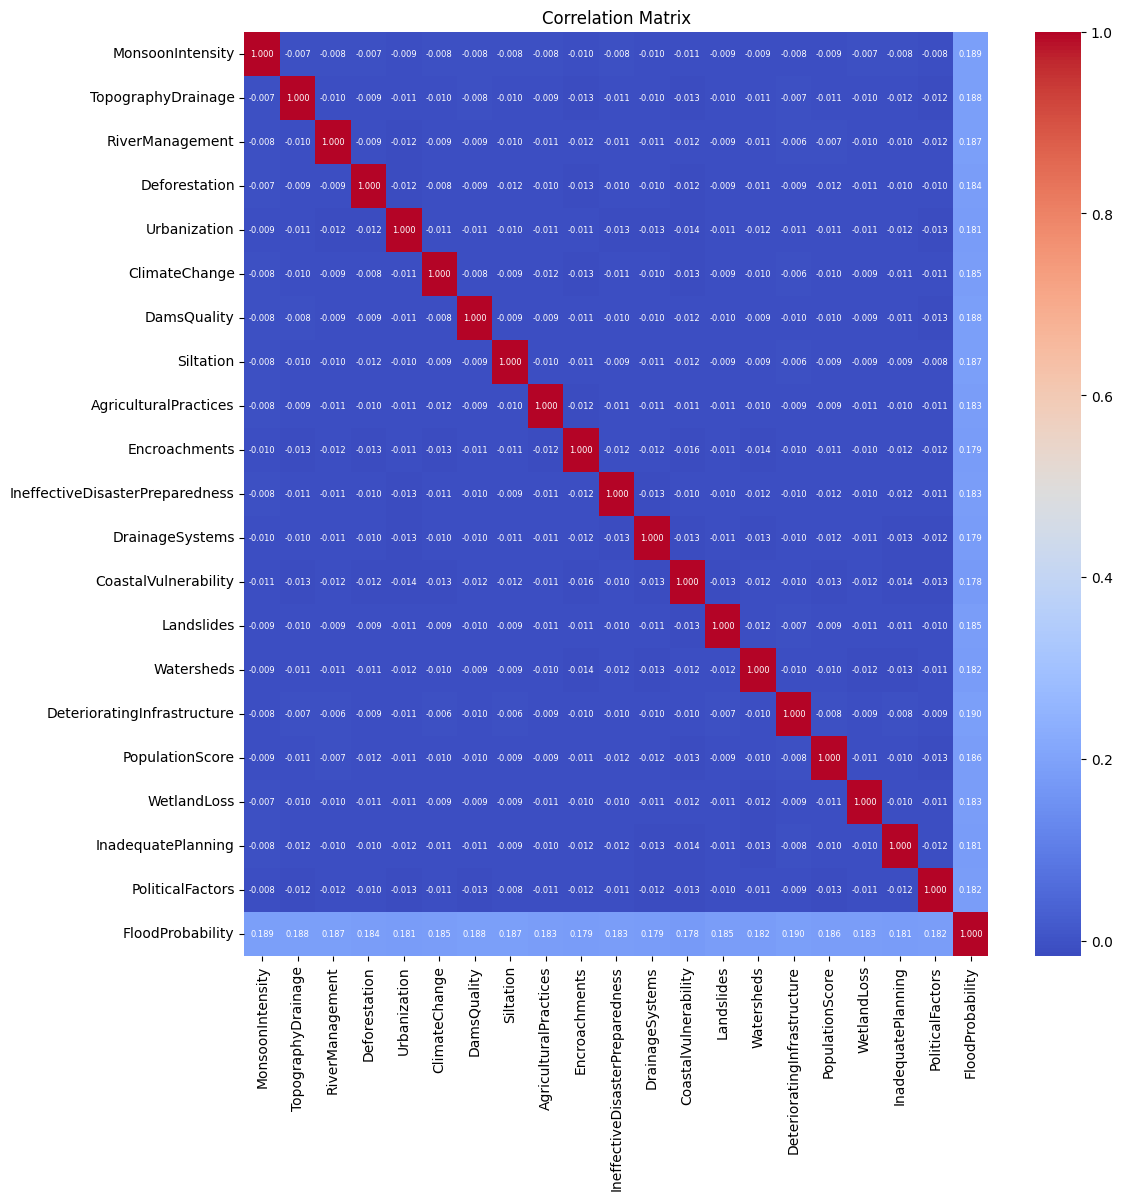

In [18]:
# Plot the heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", annot_kws={"size": 6})
plt.title('Correlation Matrix')
plt.show()

#X,y:

In [19]:
X_train = train_data.drop('FloodProbability', axis=1)
y_train = train_data['FloodProbability']


# scaler = MinMaxScaler()
scaler = StandardScaler()


#**Feature Engineering:**


In [20]:
original_features = X_train.columns

In [21]:
# Feature Engineering

def Feature_Engineering(data):

    epsilon = 1e-9

    #Statistical new Features:
    data['mean'] = data[original_features].mean(axis=1)
    data['std'] = data[original_features].std(axis=1)
    data['max'] = data[original_features].max(axis=1)
    data['min'] = data[original_features].min(axis=1)
    data['median'] = data[original_features].median(axis=1)
    data['ptp'] = data[original_features].values.ptp(axis=1)
    data['q25'] = data[original_features].quantile(0.25, axis=1)
    data['q75'] = data[original_features].quantile(0.75, axis=1)

    # Infrastructure and Climate Interactions:
    data['InfrastructurePreventionInteraction'] = (data['DamsQuality'] + data['DrainageSystems'] + \
    data['DeterioratingInfrastructure'] ) * (data['RiverManagement'] + \
    data['IneffectiveDisasterPreparedness'] + data['InadequatePlanning'])

    data['ClimateAnthropogenicInteraction'] = (data['MonsoonIntensity'] + data['ClimateChange'] ) * \
    (data['Deforestation'] + data['Urbanization'] + data['AgriculturalPractices'] + data['Encroachments'] )

    return data


X_train = Feature_Engineering(X_train)


#split data

In [22]:
# Train-test split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


#Evaluation

In [23]:
# Evaluation function
def evaluation(model_name, pipeline_model, X_train, y_train, X_test, y_test):
    pipeline_model.fit(X_train, y_train)
    y_pred_train = pipeline_model.predict(X_train)
    y_pred_test = pipeline_model.predict(X_test)

    r2_train = r2_score(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    print(f'\n{model_name} Evaluation:')
    print(f'Train R²: {r2_train:.7f}')
    print(f'Train RMSE: {rmse_train:.5f}')
    print(f'Test R²: {r2_test:.7f}')
    print(f'Test RMSE: {rmse_test:.5f}')

# Hyperparameter Tuning with optuna

In [24]:
# Objective function for each model
def objective(trial, model_class, X_train, y_train, X_test, y_test):
    if model_class == XGBRegressor:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 600, 1000),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 1.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.01, 1.0),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
        }
        model = model_class(**params, random_state=42)

    elif model_class == LGBMRegressor:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 600, 1000),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 1.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.01, 1.0)
        }
        model = model_class(**params, min_child_samples=114, force_col_wise=True, num_leaves=183, random_state=42)

    elif model_class == CatBoostRegressor:
        params = {
            'iterations': trial.suggest_int('iterations', 2000, 4000),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
            'depth': trial.suggest_int('depth', 3, 10),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 10)
        }
        model = model_class(**params, random_state=42, subsample=0.8, verbose=0)

    # Create pipeline with StandardScaler and model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return r2_score(y_test, y_pred)


In [25]:
# Function to tune hyperparameters
def tune_hyperparameters(X_train, y_train, X_test, y_test, model_class, n_trials=40):
    study = optuna.create_study(direction='maximize', sampler=TPESampler())
    study.optimize(lambda trial: objective(trial, model_class, X_train, y_train, X_test, y_test), n_trials=n_trials)
    return study.best_params


#XGBRegressor

In [ ]:
# Tune hyperparameters for XGBRegressor
xgb_best_params = tune_hyperparameters(X_tr, y_tr, X_val, y_val, XGBRegressor)
pipeline_model_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(**xgb_best_params, random_state=42))
])
print("Best parameters for XGBoost:", xgb_best_params)
evaluation('XGBoost', pipeline_model_xgb, X_tr, y_tr, X_val, y_val)

[I 2024-07-05 12:19:51,376] A new study created in memory with name: no-name-e54cc1a8-97c1-4aab-9484-4c51b2251807
[I 2024-07-05 12:21:11,469] Trial 0 finished with value: 0.868702499306453 and parameters: {'n_estimators': 827, 'learning_rate': 0.08798684143240938, 'reg_alpha': 0.805273168476185, 'reg_lambda': 0.5086770598407558}. Best is trial 0 with value: 0.868702499306453.
[I 2024-07-05 12:22:21,699] Trial 1 finished with value: 0.8687127599076014 and parameters: {'n_estimators': 696, 'learning_rate': 0.0781890234293282, 'reg_alpha': 0.8073188862452609, 'reg_lambda': 0.5083862983573921}. Best is trial 1 with value: 0.8687127599076014.
[I 2024-07-05 12:23:42,392] Trial 2 finished with value: 0.8687060121144797 and parameters: {'n_estimators': 830, 'learning_rate': 0.08251777372486797, 'reg_alpha': 0.8004214681629807, 'reg_lambda': 0.5067720959826599}. Best is trial 1 with value: 0.8687127599076014.
[I 2024-07-05 12:24:57,911] Trial 3 finished with value: 0.8687204150956569 and parame

Best parameters for XGBoost: {'n_estimators': 853, 'learning_rate': 0.07802434435330155, 'reg_alpha': 0.8094247518060815, 'reg_lambda': 0.5076125530599664}

XGBoost Evaluation:
Train R²: 0.8726058
Train RMSE: 0.01822
Test R²: 0.8686529
Test RMSE: 0.01848


#LGBMRegressor

In [ ]:
# Tune hyperparameters for LGBMRegressor
lgbm_best_params = tune_hyperparameters(X_tr, y_tr, X_val, y_val, LGBMRegressor)
pipeline_model_lgbm = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMRegressor(**lgbm_best_params, random_state=42))
])
print("Best parameters for LightGBM:", lgbm_best_params)
evaluation('LightGBM', pipeline_model_lgbm, X_tr, y_tr, X_val, y_val)


[I 2024-07-05 13:13:40,278] A new study created in memory with name: no-name-e4eca6be-338c-4cf5-be6c-7fb977a41b5c


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:15:23,369] Trial 0 finished with value: 0.8685629493806244 and parameters: {'n_estimators': 973, 'learning_rate': 0.1492888254856228, 'max_depth': 4}. Best is trial 0 with value: 0.8685629493806244.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:17:00,413] Trial 1 finished with value: 0.8685830789382811 and parameters: {'n_estimators': 913, 'learning_rate': 0.11250634289778173, 'max_depth': 4}. Best is trial 1 with value: 0.8685830789382811.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:18:42,789] Trial 2 finished with value: 0.8685907259395604 and parameters: {'n_estimators': 951, 'learning_rate': 0.10288575161392038, 'max_depth': 4}. Best is trial 2 with value: 0.8685907259395604.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:20:26,958] Trial 3 finished with value: 0.8685651224699297 and parameters: {'n_estimators': 986, 'learning_rate': 0.12134466101643321, 'max_depth': 4}. Best is trial 2 with value: 0.8685907259395604.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:22:02,449] Trial 4 finished with value: 0.8685991258032326 and parameters: {'n_estimators': 901, 'learning_rate': 0.10510811681681885, 'max_depth': 4}. Best is trial 4 with value: 0.8685991258032326.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:23:48,492] Trial 5 finished with value: 0.8685932069344329 and parameters: {'n_estimators': 962, 'learning_rate': 0.12192293972841915, 'max_depth': 4}. Best is trial 4 with value: 0.8685991258032326.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:25:31,267] Trial 6 finished with value: 0.8685867890190375 and parameters: {'n_estimators': 958, 'learning_rate': 0.1201758030256439, 'max_depth': 4}. Best is trial 4 with value: 0.8685991258032326.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:27:10,559] Trial 7 finished with value: 0.8686329793818469 and parameters: {'n_estimators': 925, 'learning_rate': 0.14356466776461188, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:28:46,662] Trial 8 finished with value: 0.8686213116359102 and parameters: {'n_estimators': 893, 'learning_rate': 0.12338623077385985, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:30:15,345] Trial 9 finished with value: 0.8683303814419251 and parameters: {'n_estimators': 961, 'learning_rate': 0.10536383646481345, 'max_depth': 3}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:31:40,328] Trial 10 finished with value: 0.8684728753044504 and parameters: {'n_estimators': 926, 'learning_rate': 0.14787890888459893, 'max_depth': 3}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:33:00,434] Trial 11 finished with value: 0.8683927180034785 and parameters: {'n_estimators': 884, 'learning_rate': 0.13621515274533866, 'max_depth': 3}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:34:35,177] Trial 12 finished with value: 0.8685594208176473 and parameters: {'n_estimators': 881, 'learning_rate': 0.1345360665616541, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:36:16,447] Trial 13 finished with value: 0.8686208047887357 and parameters: {'n_estimators': 930, 'learning_rate': 0.13374449420858323, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:37:38,953] Trial 14 finished with value: 0.8684269441354449 and parameters: {'n_estimators': 903, 'learning_rate': 0.12911943648813923, 'max_depth': 3}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:39:20,070] Trial 15 finished with value: 0.8685778685070622 and parameters: {'n_estimators': 937, 'learning_rate': 0.1419245970971956, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:40:58,828] Trial 16 finished with value: 0.8685767275898555 and parameters: {'n_estimators': 916, 'learning_rate': 0.11315198611450966, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:42:20,726] Trial 17 finished with value: 0.8683575548036575 and parameters: {'n_estimators': 896, 'learning_rate': 0.12723802182379132, 'max_depth': 3}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:44:10,086] Trial 18 finished with value: 0.8686005540847377 and parameters: {'n_estimators': 1000, 'learning_rate': 0.1127604432369502, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:45:49,764] Trial 19 finished with value: 0.8686035256313253 and parameters: {'n_estimators': 917, 'learning_rate': 0.14264046508150374, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:47:16,539] Trial 20 finished with value: 0.8684095290369788 and parameters: {'n_estimators': 944, 'learning_rate': 0.1278995087625563, 'max_depth': 3}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:48:58,086] Trial 21 finished with value: 0.8685906249482387 and parameters: {'n_estimators': 934, 'learning_rate': 0.13482846424440745, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:50:33,672] Trial 22 finished with value: 0.8685872042553426 and parameters: {'n_estimators': 892, 'learning_rate': 0.1396390374508471, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:52:14,938] Trial 23 finished with value: 0.868559802044778 and parameters: {'n_estimators': 925, 'learning_rate': 0.13109640978624074, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:53:53,533] Trial 24 finished with value: 0.8685793678121135 and parameters: {'n_estimators': 906, 'learning_rate': 0.12530434096459028, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:55:35,359] Trial 25 finished with value: 0.868590130786511 and parameters: {'n_estimators': 928, 'learning_rate': 0.11772807811461265, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:57:18,260] Trial 26 finished with value: 0.868558694850432 and parameters: {'n_estimators': 945, 'learning_rate': 0.14490999437549884, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 13:58:57,752] Trial 27 finished with value: 0.8685833833320579 and parameters: {'n_estimators': 910, 'learning_rate': 0.1332109769040915, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 14:00:37,973] Trial 28 finished with value: 0.8685748882856905 and parameters: {'n_estimators': 920, 'learning_rate': 0.13667905263237484, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 14:02:24,604] Trial 29 finished with value: 0.8685895118124672 and parameters: {'n_estimators': 975, 'learning_rate': 0.1484485791216301, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 14:04:02,036] Trial 30 finished with value: 0.8686078720135852 and parameters: {'n_estimators': 890, 'learning_rate': 0.13892557347928702, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 14:05:39,290] Trial 31 finished with value: 0.8685882300169119 and parameters: {'n_estimators': 888, 'learning_rate': 0.13953200238497493, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 14:07:17,944] Trial 32 finished with value: 0.868589926318003 and parameters: {'n_estimators': 896, 'learning_rate': 0.13885980475453202, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 14:08:57,109] Trial 33 finished with value: 0.8685979545326364 and parameters: {'n_estimators': 909, 'learning_rate': 0.14423754477381723, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 14:10:39,202] Trial 34 finished with value: 0.8685752744349391 and parameters: {'n_estimators': 931, 'learning_rate': 0.11719640038756222, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 14:12:18,223] Trial 35 finished with value: 0.8685571014218574 and parameters: {'n_estimators': 897, 'learning_rate': 0.12464408237152066, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 14:14:03,377] Trial 36 finished with value: 0.8685853291736054 and parameters: {'n_estimators': 952, 'learning_rate': 0.1311089835048184, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 14:15:39,615] Trial 37 finished with value: 0.8685676291449399 and parameters: {'n_estimators': 884, 'learning_rate': 0.14662266000853263, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 14:17:16,960] Trial 38 finished with value: 0.8686065100438036 and parameters: {'n_estimators': 890, 'learning_rate': 0.1496096724203326, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-05 14:19:03,867] Trial 39 finished with value: 0.8685892395772468 and parameters: {'n_estimators': 969, 'learning_rate': 0.13223632802203142, 'max_depth': 4}. Best is trial 7 with value: 0.8686329793818469.


Best parameters for LightGBM: {'n_estimators': 925, 'learning_rate': 0.14356466776461188, 'max_depth': 4}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

#CatBoostRegressor

In [ ]:
# Tune hyperparameters for CatBoostRegressor
catboost_best_params = tune_hyperparameters(X_tr, y_tr, X_val, y_val, CatBoostRegressor)
pipeline_model_catboost = Pipeline([
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(**catboost_best_params, random_state=42, verbose=0))
])
print("Best parameters for CatBoost:", catboost_best_params)
evaluation('CatBoost', pipeline_model_catboost, X_tr, y_tr, X_val, y_val)


[I 2024-07-05 15:24:47,514] A new study created in memory with name: no-name-d758686d-7037-481f-8950-4897e38c25af
[I 2024-07-05 15:32:37,386] Trial 0 finished with value: 0.8687623256389573 and parameters: {'iterations': 2255, 'learning_rate': 0.03589470487201991, 'depth': 8, 'l2_leaf_reg': 4.025796860131146}. Best is trial 0 with value: 0.8687623256389573.
[I 2024-07-05 15:41:18,726] Trial 1 finished with value: 0.8687564038661978 and parameters: {'iterations': 2531, 'learning_rate': 0.03177113110786933, 'depth': 8, 'l2_leaf_reg': 4.569391561577275}. Best is trial 0 with value: 0.8687623256389573.
[I 2024-07-05 15:48:05,706] Trial 2 finished with value: 0.8687485891875928 and parameters: {'iterations': 2195, 'learning_rate': 0.036636499112716554, 'depth': 7, 'l2_leaf_reg': 4.883859964715072}. Best is trial 0 with value: 0.8687623256389573.
[I 2024-07-05 15:57:23,604] Trial 3 finished with value: 0.8687364486514534 and parameters: {'iterations': 3006, 'learning_rate': 0.031824921428827

Best parameters for CatBoost: {'iterations': 2737, 'learning_rate': 0.035052689984380665, 'depth': 8, 'l2_leaf_reg': 4.1449084718774545}

CatBoost Evaluation:
Train R²: 0.8728868
Train RMSE: 0.01820
Test R²: 0.8687694
Test RMSE: 0.01847


#VotingRegressor

In [26]:
# These values are obtained from Optuna's optimization function
xgb_best_params = {
    'n_estimators': 853,
    'learning_rate': 0.07802434435330155,
    'max_depth': 5,
    'reg_alpha': 0.8094247518060815,
    'reg_lambda': 0.5076125530599664,
    'min_child_weight':2
}

lgbm_best_params = {
    'n_estimators': 925,
    'learning_rate': 0.14356466776461188,
    'max_depth': 4,
    'min_child_samples':114,
    'force_col_wise':'True',
    'num_leaves':183
#     'reg_alpha': 0,
#     'reg_lambda': 0.,
}

catboost_best_params = {
    'iterations': 2737,
    'learning_rate': 0.035052689984380665,
    'depth': 8,
    'l2_leaf_reg': 4.1449084718774545,
    'subsample':0.8
}

In [ ]:
# Voting Regressor Tuning
def tune_voting_regressor(X_train, y_train, X_test, y_test, xgb_params, lgbm_params, catboost_params, n_trials=15):
    def objective(trial):
        weight_xgb = trial.suggest_int('weight_xgb', 4, 10)
        weight_lgbm = trial.suggest_int('weight_lgbm', 1, 4)
        weight_catboost = trial.suggest_int('weight_catboost', 4, 10)

        xgb_model = XGBRegressor(**xgb_params, random_state=42)
        lgbm_model = LGBMRegressor(**lgbm_params, random_state=42)
        catboost_model = CatBoostRegressor(**catboost_params, random_state=42, verbose=0)

        voting_reg = VotingRegressor(
            estimators=[
                ('xgb', xgb_model),
                ('lgbm', lgbm_model),
                ('catboost', catboost_model)
            ],
            weights=[weight_xgb, weight_lgbm, weight_catboost]
        )

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', voting_reg)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        return r2_score(y_test, y_pred)

    study = optuna.create_study(direction='maximize', sampler=TPESampler())
    study.optimize(objective, n_trials=n_trials)
    return study.best_params

voting_best_params = tune_voting_regressor(X_tr, y_tr, X_val, y_val, xgb_best_params, lgbm_best_params, catboost_best_params)
print("Best parameters for Voting Regressor:", voting_best_params)


In [27]:


voting_regressor = VotingRegressor(
    estimators=[
        ('xgb', XGBRegressor(**xgb_best_params, random_state=42)),
        ('lgbm', LGBMRegressor(**lgbm_best_params, random_state=42)),
        ('catboost', CatBoostRegressor(**catboost_best_params, random_state=42, verbose=0))
    ],
    # weights=[voting_best_params['weight_xgb'], voting_best_params['weight_lgbm'], voting_best_params['weight_catboost']]
    weights=[6, 2, 8]

)

pipeline_voting = Pipeline([
    ('scaler', StandardScaler()),
    ('model', voting_regressor)
])

# Evaluate Voting Regressor
evaluation('Voting Regressor', pipeline_voting, X_tr, y_tr, X_val, y_val)


[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

#Training

In [29]:
# Fit the pipeline on the entire training data
pipeline_model = pipeline_voting.fit(X_train, y_train)
y_pred_train = pipeline_voting.predict(X_train)

# Calculate the evaluation metrics on the entire training data
train_r2 = r2_score(y_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))

# Print the evaluation metrics on the train data
print("Train R2 score:", train_r2)
print("Train RMSE:", train_rmse)

[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1117957, number of used features: 30
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

#Test

In [30]:
test_data = pd.read_csv('/content/dataset/test.csv')

print('Shape of test data is : ' , test_data.shape)
print('test data columns: ' , test_data.columns)

Shape of test data is :  (745305, 21)
test data columns:  Index(['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors'],
      dtype='object')


In [31]:
test_ids = test_data['id']
test_data = test_data.drop('id', axis=1)

In [32]:
# feature engineering

test_data = Feature_Engineering(test_data)

In [33]:

print('test data columns: ' , test_data.columns)

test data columns:  Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'mean', 'std', 'max', 'min',
       'median', 'ptp', 'q25', 'q75', 'InfrastructurePreventionInteraction',
       'ClimateAnthropogenicInteraction'],
      dtype='object')


In [34]:
print('Shape of test data is : ' , test_data.shape)

Shape of test data is :  (745305, 30)


In [35]:
# Predict the test data
y_pred_test = pipeline_voting.predict(test_data)
y_pred_test

array([0.57842888, 0.45730375, 0.44892847, ..., 0.62170575, 0.54913688,
       0.52838027])

In [36]:
# Create a DataFrame with id column and predictions
submission_df = pd.DataFrame({'id': test_ids, 'FloodProbability': y_pred_test})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)